## Supreme Court Voting Patterns

Plots of how the Supreme Court Justices have voted over the years, exploring which Justices most commonly vote together and how "split" any given court is.
Data is provided by http://scdb.wustl.edu/data.php

In [131]:
import os
import pathlib as path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from sklearn.cluster import KMeans

In [3]:
# Data is stored in same path as this script:
scriptPath = path.Path(os.path.realpath('SupremeCourtNetwork.ipynb'))
datapath = path.Path(scriptPath.parent , 'SCDB_2024_01_justiceCentered_Docket.csv')
df = pd.read_csv(path.Path(datapath))
print('A random sample of Supreme Court case outcomes:')
df.loc[:,['caseName','dateDecision','chief','majVotes','minVotes']].sample(10,random_state=42).sort_index()

A random sample of Supreme Court case outcomes:


,caseName,dateDecision,chief,majVotes,minVotes
9555,"CHICAGO, ROCK ISLAND & PACIFIC RAILROAD CO. v....",1/18/54,Warren,7,2
25182,NATIONAL LABOR RELATIONS BOARD v. METROPOLITAN...,4/5/65,Warren,8,1
35642,In re BURRUS et al.,6/21/71,Burger,5,4
46368,VENDO CO. v. LEKTRO-VEND CORP. et al.,6/29/77,Burger,5,4
60419,UNITED STATES v. MAINE et al.,2/25/86,Burger,8,0
69454,"THOMAS C. RAPONE, COMMISSIONER OF CORRECTION O...",1/15/92,Rehnquist,6,2
74857,COMMISSIONER OF INTERNAL REVENUE v. ESTATE OF ...,3/18/97,Rehnquist,7,2
78681,"LACKAWANNA COUNTY DISTRICT ATTORNEY, et al. v....",4/25/01,Rehnquist,5,4
89864,COMPTROLLER OF THE TREASURY v. WYNNE,5/18/15,Roberts,5,4
95760,"COINBASE, INC. v. BIELSKI",6/23/23,Roberts,5,4


The "Vote" column indicates how a justice voted on a given case:

1.	Voted with majority or plurality
2.	Dissent
3.	Regular concurrence
4.	Special concurrence
5.	Judgment of the Court
6.	Dissent from a denial or dismissal of certiorari , or dissent from summary affirmation of an appeal
7.	Jurisdictional dissent
8.	Justice participated in an equally divided vote
- 'nan' Justice did not vote/participate

For our purposes we will lump all concurrences together and all dissents together. I.E. anyone dissenting is considered voting with every other dissenting justice, and every concurrence is considered a vote with the majority. 

### First, let's look at the most recent term (2023 at time of writing):
I want to understand how polarized the Justices are in their voting patterns. To that end, I am only going to look at cases where the votes were not unanimous.

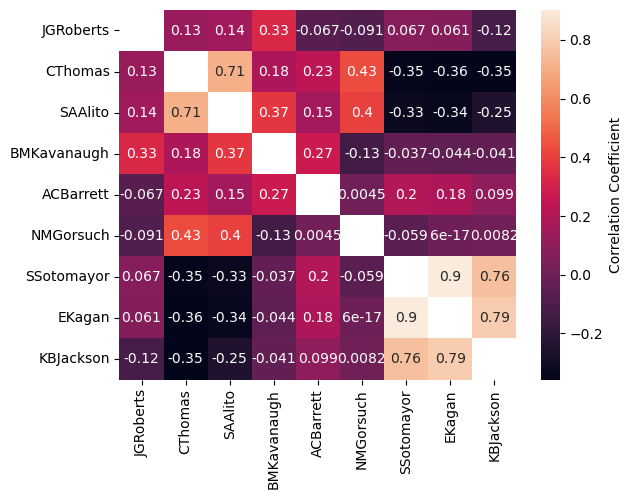

In [6]:
# Trim down to just the 2023 term:
df_2023 = df.loc[df['term'] == 2023]
# Remove all cases that were unanimous, i.e. number of dissenting votes == 0
# df_2023 = df_2023.loc[df_2023['minVotes']!=0]
# Each vote is uniquely indexed by a "Docket ID".
# This is different from a Case ID, as some cases have multiple parts and thus multiple votes. 
docketIds = df_2023['docketId'].unique()

# For ease of plotting later, I have put the justices in a static order, with Chief Justice Roberts first,
# followed by the conservative justices, then the liberal justices.
justiceOrder = ['JGRoberts', 'CThomas', 'SAAlito', 'BMKavanaugh', 'ACBarrett',
       'NMGorsuch', 'SSotomayor','EKagan','KBJackson']
# For each justice, get a vector of their votes, where 1=voting with the majority, -1=dissenting, and 0= no vote/abstain
voteMat = np.zeros([len(docketIds),len(justiceOrder)])
for i in range(len(justiceOrder)):
    j = justiceOrder[i]
    v = df_2023.loc[df_2023['justiceName']==j,'vote']
    v[v.isin([1,3,4,5])] = 1
    v[v.isin([2,7])] = -1
    v = v.fillna(0)
    v=v.to_numpy()
    voteMat[:,i] = v
# Run a correlation to see which justices are most aligned and which most often vote in opposition to eachother
corrMat = np.corrcoef(voteMat.T)
np.fill_diagonal(corrMat,'nan')
sns.heatmap(corrMat,annot=True,xticklabels=justiceOrder,yticklabels=justiceOrder,
           cbar_kws={'label': 'Correlation Coefficient'})
plt.show()
from scipy.io import savemat
savemat('voting matrix.mat',{'Justices':justiceOrder,'Votes':voteMat})

Another way to visualize this is by looking at the fraction of cases where each justice voted the same way.

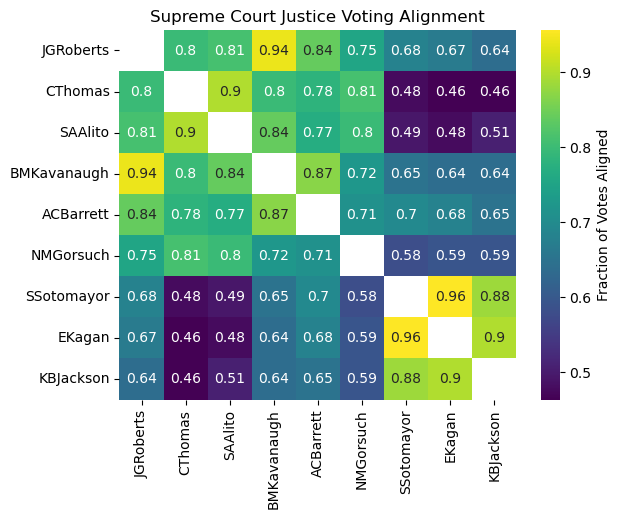

In [8]:
# Iterate over unique cases. Each vote is uniquely indexed by a "Docket ID"
docketIds = df_2023['docketId'].unique()
# For each case, create a matrix depicting which justices voted together
voteMat_count = np.zeros([9,9])
# Define an order for the justices, in case they are selected out of order:

for case in docketIds:
    currdata = df_2023[df_2023['docketId']==case]
    currdata.set_index('justiceName',inplace=True)
    votes = currdata.loc[justiceOrder,'vote']
    maj_votes = votes.isin([1,3,4,5]).to_numpy()
    dis_votes = votes.isin([2,7]).to_numpy()
    matrix = np.outer(maj_votes,maj_votes) + np.outer(dis_votes,dis_votes)
    voteMat_count += matrix


np.fill_diagonal(voteMat_count,'nan')
# Convert from counts to fraction of cases
n_cases = len(docketIds);
voteMat_frac = voteMat_count / n_cases
#print(voteMatrix)
sns.heatmap(voteMat_frac,cmap='viridis',yticklabels=justiceOrder,xticklabels=justiceOrder,
           cbar_kws={'label': 'Fraction of Votes Aligned'},annot=True)
plt.title('Supreme Court Justice Voting Alignment')
plt.show()

As expected, the conservative justices are more likely to vote with eachother than with the liberal justices. The liberal justices are similarly aligned with eachother.

### The 3-3-3 Court
One supposed theory about the Robert's court is that it is not simply divided along liberal|conservative lines, but that it is split into three groups of three justices each along liberal|moderate|conservative lines, with Roberts, Barrett, and Kavanaugh comprising the moderate camp. \
We can investigate this hypothesis by performing clustering analysis of the justices based on their voting history.

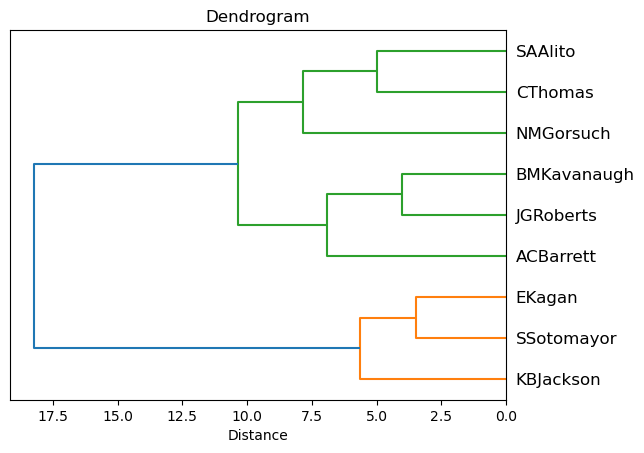

In [11]:
# Hierarchical clustering using the vote vectors (same as in our correlation matrix)
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(voteMat.T, method='ward')

plt.figure()
dendrogram(linkage_matrix,labels=justiceOrder,orientation='left',distance_sort=True)
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.show()


From this we can see that the "conservatives" Alito, Thomas, and Gorsuch are more closely aligned in their voting trends than the "moderates" Roberts, Kavanaugh, and Barret. However, the moderates are *much* closer to the conservatives than they are to the liberals. Indeed our default clustering algorithm only identifies two primary clusters, (It should be noted, though, that there are other methods of clustering that could produce a greater number of 'significant' groups).


---

Another method of visualization and quantification of Supreme Court justices' voting patterns is through a graph. Here we create a graph where each node represents a justice, and edges are drawn between justices that vote in alignment. The edge weights are equivalent to the correlation coefficient that we calculated above - negatice coefficients are ommitted and result in disconnected nodes.

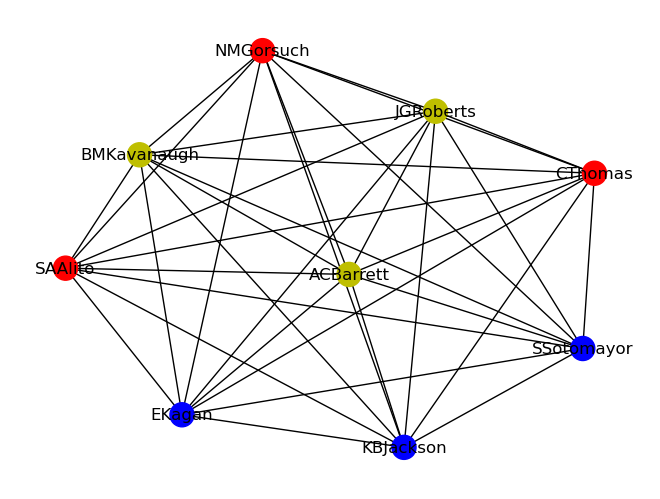

In [13]:
# Create a Graph object and use our matrix to populate it:
G = nx.Graph()
num_nodes = corrMat.shape[0]
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Only iterate over upper triangle
        # weight = corrMat[i,j]
        weight = voteMat_frac[i,j]
        if weight > 0:
            G.add_edge(i, j, weight=weight)

# Add labels to the nodes:
node_labels = {i:j for i,j in zip(range(9),justiceOrder)}
node_colors = ['y','r','r','y','y','r','b','b','b']
G = nx.relabel_nodes(G, node_labels)
pos = nx.spring_layout(G,weight='weight',seed=42,iterations=100)
nx.draw(G, pos,with_labels=True,node_color=node_colors)
plt.show()

In [14]:
def edge_weight_complement(u,v,E):
    try:
        return 1-E['weight']
    except:
        return None
edge_weight_complement(G.nodes['JGRoberts'],G.nodes['CThomas'],G.edges['JGRoberts','CThomas'])

0.2028985507246377

JGRoberts : 0
BMKavanaugh : 0.058
ACBarrett : 0.159
SAAlito : 0.188
CThomas : 0.203
NMGorsuch : 0.246
SSotomayor : 0.319
EKagan : 0.333
KBJackson : 0.362


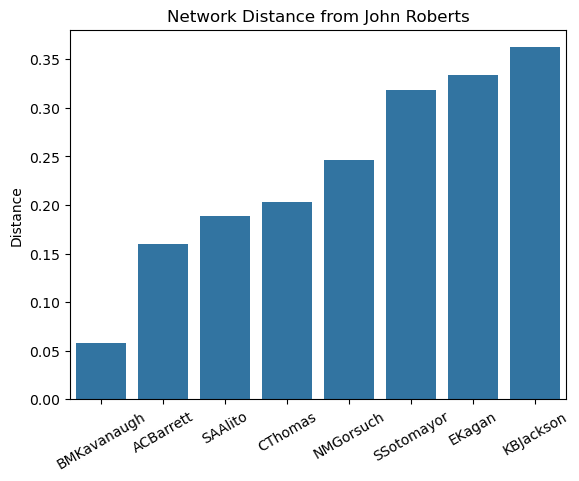

In [15]:
# Measure path length between Roberts and each other justice:
roberts_pathlengths = nx.shortest_path_length(G,source='JGRoberts',weight=edge_weight_complement)
for x in roberts_pathlengths:
    print(x,':',np.round(roberts_pathlengths[x],3))
    
sns.barplot(x=list(roberts_pathlengths.keys())[1::],y=list(roberts_pathlengths.values())[1::])
plt.xticks(rotation=30)
plt.ylabel('Distance')
plt.title('Network Distance from John Roberts')
plt.show()

SSotomayor : 0
EKagan : 0.043
KBJackson : 0.116
ACBarrett : 0.304
JGRoberts : 0.319
BMKavanaugh : 0.348
NMGorsuch : 0.42
SAAlito : 0.507
CThomas : 0.522


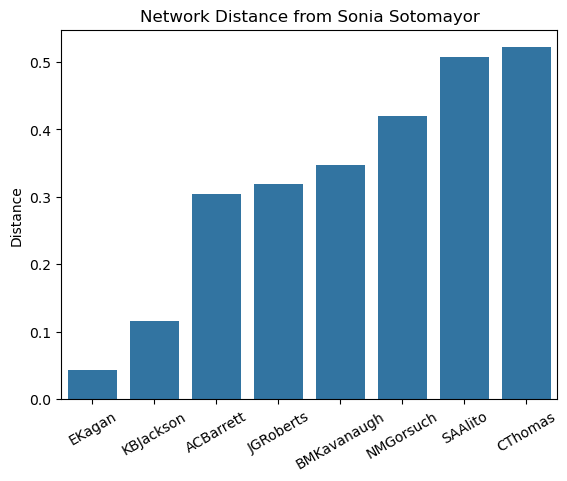

In [16]:
# Measure path length between Sotomayor and each other justice:
sotomayor_pathlengths = nx.shortest_path_length(G,source='SSotomayor',weight=edge_weight_complement)
for x in sotomayor_pathlengths:
    print(x,':',np.round(sotomayor_pathlengths[x],3))
    
sns.barplot(x=list(sotomayor_pathlengths.keys())[1::],y=list(sotomayor_pathlengths.values())[1::])
plt.xticks(rotation=30)
plt.ylabel('Distance')
plt.title('Network Distance from Sonia Sotomayor')
plt.show()

In [159]:
X = voteMat
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X.T)

C:\Users\gordo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [157]:
print(kmeans.labels_)
x = kmeans.cluster_centers_
type(x)
x[0][0]

[0 2 2 0 0 2 1 1 1]


1.0

### The Past 20 Years 
Let's look at the recent history of the court and see if we can measure how "polarized" it is over time



In [121]:
df['vote_index'] = df.index
df['vote_index']

0            0
1            1
2            2
3            3
4            4
         ...  
96572    96572
96573    96573
96574    96574
96575    96575
96576    96576
Name: vote_index, Length: 96577, dtype: int64

In [123]:
df_by_term = df.set_index(['term','docketId','vote_index'])
years = list(range(2000,2023))
idx = pd.IndexSlice
df_by_term=df_by_term.loc[idx[years,:],:]

In [125]:
for year,year_df in df_by_term.groupby('term'):
    justices = year_df['justiceName'].unique()
    print(f"YEAR: {year}, JUSTICES:{justices}")

YEAR: 2000, JUSTICES:['WHRehnquist' 'JPStevens' 'SDOConnor' 'AScalia' 'AMKennedy' 'DHSouter'
 'CThomas' 'RBGinsburg' 'SGBreyer']
YEAR: 2001, JUSTICES:['WHRehnquist' 'JPStevens' 'SDOConnor' 'AScalia' 'AMKennedy' 'DHSouter'
 'CThomas' 'RBGinsburg' 'SGBreyer']
YEAR: 2002, JUSTICES:['WHRehnquist' 'JPStevens' 'SDOConnor' 'AScalia' 'AMKennedy' 'DHSouter'
 'CThomas' 'RBGinsburg' 'SGBreyer']
YEAR: 2003, JUSTICES:['WHRehnquist' 'JPStevens' 'SDOConnor' 'AScalia' 'AMKennedy' 'DHSouter'
 'CThomas' 'RBGinsburg' 'SGBreyer']
YEAR: 2004, JUSTICES:['WHRehnquist' 'JPStevens' 'SDOConnor' 'AScalia' 'AMKennedy' 'DHSouter'
 'CThomas' 'RBGinsburg' 'SGBreyer']
YEAR: 2005, JUSTICES:['JPStevens' 'SDOConnor' 'AScalia' 'AMKennedy' 'DHSouter' 'CThomas'
 'RBGinsburg' 'SGBreyer' 'JGRoberts' 'SAAlito']
YEAR: 2006, JUSTICES:['JPStevens' 'AScalia' 'AMKennedy' 'DHSouter' 'CThomas' 'RBGinsburg'
 'SGBreyer' 'JGRoberts' 'SAAlito']
YEAR: 2007, JUSTICES:['JGRoberts' 'JPStevens' 'AScalia' 'AMKennedy' 'DHSouter' 'CThomas'
 'RB

In [113]:
df.columns

Index(['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision',
       'decisionType', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'term',
       'naturalCourt', 'chief', 'docket', 'caseName', 'dateArgument',
       'dateRearg', 'petitioner', 'petitionerState', 'respondent',
       'respondentState', 'jurisdiction', 'adminAction', 'adminActionState',
       'threeJudgeFdc', 'caseOrigin', 'caseOriginState', 'caseSource',
       'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition',
       'lcDispositionDirection', 'declarationUncon', 'caseDisposition',
       'caseDispositionUnusual', 'partyWinning', 'precedentAlteration',
       'voteUnclear', 'issue', 'issueArea', 'decisionDirection',
       'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2',
       'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter', 'majOpinAssigner',
       'splitVote', 'majVotes', 'minVotes', 'justice', 'justiceName', 'vote',
       'opinion', 'direction', 'majority', 'firstA